In [1]:
pip install torchvision torchmetrics hub

Note: you may need to restart the kernel to use updated packages.


### **1. Visualize**

In [2]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time
import argparse

import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import ssd
from torchvision.models.detection import ssd300_vgg16
import matplotlib.patches as patches

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:01<00:00, 293MB/s]  


105 98 368 505


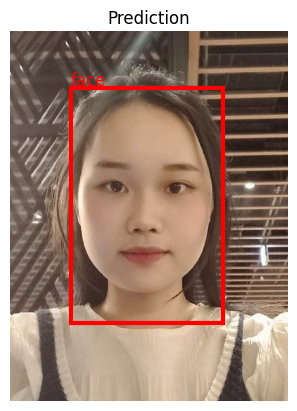

In [3]:

model = ssd300_vgg16(num_classes = 2)
model.load_state_dict(torch.load('/kaggle/input/modell/ssd_119.pth'))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

CLASSES = ['__background__', 'face']

image = cv2.imread('/kaggle/input/anh-test/12.jpg')

orig_image = image.copy()
image = cv2.resize(image, (300, 300))
# print(image.shape)

# BGR to RGB.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

# Make the pixel range between 0 and 1.
image /= 255.0

# Bring color channels to front (H, W, C) => (C, H, W).
image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)

# Convert to tensor.
image_input = torch.tensor(image_input, dtype=torch.float).cuda()

# Add batch dimension.
image_input = torch.unsqueeze(image_input, 0)

model.eval()

# Predictions
with torch.no_grad():
    outputs = model(image_input.to(DEVICE))
#     print(outputs)

# Load all detection to CPU for further operations.
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# Carry further only if there are detected boxes.
if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()    
    scores = np.array(outputs[0]['scores'].data)

    # Find the maximum value
    max_value = np.max(scores)

    # Find the second maximum value
    second_max_value = np.partition(scores, -2)[-2]
    
#     boxes = boxes[scores == second_max_value].astype(np.int32)
    boxes = boxes[scores == max_value].astype(np.int32)
    
#     print(boxes)
    draw_boxes = boxes.copy()
    
    # Get all the predicited class names.
    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
    
    ax = plt.gca()

    # Draw the bounding boxes and write the class name on top of it.
    for j, box in enumerate(draw_boxes):
        class_name = pred_classes[j]

        # Recale boxes.
        xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
        ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
        xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
        ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
        
        print(xmin, ymin, xmax, ymax)
        # Create a rectangle patch
        rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      linewidth=3, edgecolor='red', facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rectangle)

        # Add text
        plt.text(xmin, ymin - 5, class_name, fontsize=12, color='red')


    # Display the image in a window named 'Image'
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.title('Prediction')
    plt.axis('off')
    plt.show()


### **2. Evaluate**

In [5]:
pip install hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 kB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for humbug>=0.3.1 from https://files.pythonhosted.org/packages/c8/cc/c8129d6e9a1f473b5e90cf1b8eac43191a22657b9b673e02815548662270/humbug-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for libdeeplake==0.0.95 from https://files.pythonhosted.org/packages/68/47/af028040402ccdfc498da2521789d3dfe514af50354a13cb3a4f90a3650b/libdeeplake-0.0.95-cp310-cp310-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for aioboto3>=10.4.0 from https://files.pythonhosted.org/packages/75/50/e56cabec21ee746e7245d0a3d87f4e8c788b5249486ad1351dbfc01249ff/aioboto3-12.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/81/bf/1dccda444cede321eafc7ae880387df08fa958

In [6]:
import deeplake
ds = deeplake.load("hub://activeloop/celeb-a-train")[:1000]

|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



/

hub://activeloop/celeb-a-train loaded successfully.



/opt/conda/lib/python3.10/site-packages/deeplake/api/dataset.py:754: UserWarning: Dataset has more than 20 tensors. Skipping integrity check. Specify `check_integrity=True` to perform integrity check.
  warnings.warn(



#### Create label dataframe

In [ ]:
def convert_to_XYXY(anno_list, idx):
    ret = []

    boxes = np.array(anno_list[idx])

    for i in range(len(boxes)):
        bbox = np.array(boxes)[i]
#         print(bbox)
        xmin = bbox[0]
        ymin = bbox[1]
        widthb = bbox[2]  # Width and height of bbox
        heightb = bbox[3]
        xmax = xmin + widthb
        ymax = ymin + heightb

        ret.append([xmin, ymin, xmax, ymax])

    return np.array(ret)

In [ ]:
# id, xmin, ymin, xmax, ymax, label, image_name
import pandas as pd

label_df = pd.DataFrame()

xmin = []
ymin = []
xmax = []
ymax = []
image_name = []

for idx in range(0,1000):
    bboxes = convert_to_XYXY(ds['boxes'], idx)
    for bbox in bboxes:
        x1, y1 = bbox[0], bbox[1]
        x2, y2 = bbox[2], bbox[3]

        xmin.append(x1)
        ymin.append(y1)
        xmax.append(x2)
        ymax.append(y2)
        
        image_name.append(idx)

label_df['xmin'] = xmin
label_df['ymin'] = ymin
label_df['xmax'] = xmax
label_df['ymax'] = ymax
label = ['face'] * len(image_name)
label_df['label'] = label
label_df['image_name'] = image_name

label_df = label_df.reset_index().rename(columns = {'index':'id'})
label_df.to_csv('label_df.csv')
label_df


#### Create prediction dataframe

In [ ]:
# id, xmin, ymin, xmax, ymax, label, score, image_name
model = ssd300_vgg16(num_classes = 2)
model.load_state_dict(torch.load('/kaggle/input/modell/ssd_119.pth'))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

CLASSES = ['__background__', 'face']

preds_df = pd.DataFrame()

xmin = []
ymin = []
xmax = []
ymax = []
image_name = []
score = []
for idx in range(0, 1000):
    
    if idx % 50 == 0:
        print(idx)
    image = ds['images'][idx]
    gt = ds['boxes'][idx]

    orig_image = image
#     print(orig_image.shape)
    image = cv2.resize(np.array(image), (300, 300))
#     print(image.shape)

    # BGR to RGB.
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = image.astype(np.float32)

    # Make the pixel range between 0 and 1.
    image /= 255.0

    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)

    # Convert to tensor.
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()

    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)

    model.eval()

    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
#         print(outputs)

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()    
        scores = np.array(outputs[0]['scores'].data)

        # Find the maximum value
        max_value = np.max(scores)

        # Find the second maximum value
        second_max_value = np.partition(scores, -2)[-2]

        boxes = boxes[scores >= 0.5].astype(np.int32)
        scores = scores[scores >= 0.5]
        
#         if idx >= 500:
#             print(idx, boxes)
        draw_boxes = boxes.copy()

        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Draw the bounding boxes and write the class name on top of it.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]

            # Recale boxes.
            x1 = int((box[0] / image.shape[1]) * orig_image.shape[1])
            y1 = int((box[1] / image.shape[0]) * orig_image.shape[0])
            x2 = int((box[2] / image.shape[1]) * orig_image.shape[1])
            y2 = int((box[3] / image.shape[0]) * orig_image.shape[0])
            
            xmin.append(x1)
            ymin.append(y1)
            xmax.append(x2)
            ymax.append(y2)
            
            score.append(scores[j])
            
            image_name.append(idx)
            
preds_df['xmin'] = xmin
preds_df['ymin'] = ymin
preds_df['xmax'] = xmax
preds_df['ymax'] = ymax
label = ['face'] * len(image_name)
preds_df['label'] = label
preds_df['score'] = score
preds_df['image_name'] = image_name

preds_df = preds_df.reset_index().rename(columns = {'index':'id'})
preds_df

In [ ]:
preds_df.to_csv('pred_df.csv')

In [ ]:
from enum import Enum

import cv2


class MethodAveragePrecision(Enum):
    """
    Class representing if the coordinates are relative to the
    image size or are absolute values.

        Developed by: Rafael Padilla
        Last modification: Apr 28 2018
    """
    EveryPointInterpolation = 1
    ElevenPointInterpolation = 2


class CoordinatesType(Enum):
    """
    Class representing if the coordinates are relative to the
    image size or are absolute values.

        Developed by: Rafael Padilla
        Last modification: Apr 28 2018
    """
    Relative = 1
    Absolute = 2


class BBType(Enum):
    """
    Class representing if the bounding box is groundtruth or not.

        Developed by: Rafael Padilla
        Last modification: May 24 2018
    """
    GroundTruth = 1
    Detected = 2


class BBFormat(Enum):
    """
    Class representing the format of a bounding box.
    It can be (X,Y,width,height) => XYWH
    or (X1,Y1,X2,Y2) => XYX2Y2

        Developed by: Rafael Padilla
        Last modification: May 24 2018
    """
    XYWH = 1
    XYX2Y2 = 2


# size => (width, height) of the image
# box => (X1, X2, Y1, Y2) of the bounding box
def convertToRelativeValues(size, box):
    dw = 1. / (size[0])
    dh = 1. / (size[1])
    cx = (box[1] + box[0]) / 2.0
    cy = (box[3] + box[2]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = cx * dw
    y = cy * dh
    w = w * dw
    h = h * dh
    # x,y => (bounding_box_center)/width_of_the_image
    # w => bounding_box_width / width_of_the_image
    # h => bounding_box_height / height_of_the_image
    return (x, y, w, h)


# size => (width, height) of the image
# box => (centerX, centerY, w, h) of the bounding box relative to the image
def convertToAbsoluteValues(size, box):
    # w_box = round(size[0] * box[2])
    # h_box = round(size[1] * box[3])
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)


def add_bb_into_image(image, bb, color=(255, 0, 0), thickness=2, label=None):
    r = int(color[0])
    g = int(color[1])
    b = int(color[2])

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontThickness = 1

    x1, y1, x2, y2 = bb.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (b, g, r), thickness)
    # Add label
    if label is not None:
        # Get size of the text box
        (tw, th) = cv2.getTextSize(label, font, fontScale, fontThickness)[0]
        # Top-left coord of the textbox
        (xin_bb, yin_bb) = (x1 + thickness, y1 - th + int(12.5 * fontScale))
        # Checking position of the text top-left (outside or inside the bb)
        if yin_bb - th <= 0:  # if outside the image
            yin_bb = y1 + th  # put it inside the bb
        r_Xin = x1 - int(thickness / 2)
        r_Yin = y1 - th - int(thickness / 2)
        # Draw filled rectangle to put the text in it
        cv2.rectangle(image, (r_Xin, r_Yin - thickness),
                      (r_Xin + tw + thickness * 3, r_Yin + th + int(12.5 * fontScale)), (b, g, r),
                      -1)
        cv2.putText(image, label, (xin_bb, yin_bb), font, fontScale, (0, 0, 0), fontThickness,
                    cv2.LINE_AA)
    return image

class BoundingBox:
    def __init__(self,
                 imageName,
                 classId,
                 x,
                 y,
                 w,
                 h,
                 typeCoordinates=CoordinatesType.Absolute,
                 imgSize=None,
                 bbType=BBType.GroundTruth,
                 classConfidence=None,
                 format=BBFormat.XYWH):
        """Constructor.
        Args:
            imageName: String representing the image name.
            classId: String value representing class id.
            x: Float value representing the X upper-left coordinate of the bounding box.
            y: Float value representing the Y upper-left coordinate of the bounding box.
            w: Float value representing the width bounding box.
            h: Float value representing the height bounding box.
            typeCoordinates: (optional) Enum (Relative or Absolute) represents if the bounding box
            coordinates (x,y,w,h) are absolute or relative to size of the image. Default:'Absolute'.
            imgSize: (optional) 2D vector (width, height)=>(int, int) represents the size of the
            image of the bounding box. If typeCoordinates is 'Relative', imgSize is required.
            bbType: (optional) Enum (Groundtruth or Detection) identifies if the bounding box
            represents a ground truth or a detection. If it is a detection, the classConfidence has
            to be informed.
            classConfidence: (optional) Float value representing the confidence of the detected
            class. If detectionType is Detection, classConfidence needs to be informed.
            format: (optional) Enum (BBFormat.XYWH or BBFormat.XYX2Y2) indicating the format of the
            coordinates of the bounding boxes. BBFormat.XYWH: <left> <top> <width> <height>
            BBFormat.XYX2Y2: <left> <top> <right> <bottom>.
        """
        self._imageName = imageName
        self._typeCoordinates = typeCoordinates
        if typeCoordinates == CoordinatesType.Relative and imgSize is None:
            raise IOError(
                'Parameter \'imgSize\' is required. It is necessary to inform the image size.')
        if bbType == BBType.Detected and classConfidence is None:
            raise IOError(
                'For bbType=\'Detection\', it is necessary to inform the classConfidence value.')
        # if classConfidence != None and (classConfidence < 0 or classConfidence > 1):
        # raise IOError('classConfidence value must be a real value between 0 and 1. Value: %f' %
        # classConfidence)

        self._classConfidence = classConfidence
        self._bbType = bbType
        self._classId = classId
        self._format = format

        # If relative coordinates, convert to absolute values
        # For relative coords: (x,y,w,h)=(X_center/img_width , Y_center/img_height)
        if (typeCoordinates == CoordinatesType.Relative):
            (self._x, self._y, self._w, self._h) = convertToAbsoluteValues(imgSize, (x, y, w, h))
            self._width_img = imgSize[0]
            self._height_img = imgSize[1]
            if format == BBFormat.XYWH:
                self._x2 = self._w
                self._y2 = self._h
                self._w = self._x2 - self._x
                self._h = self._y2 - self._y
            else:
                raise IOError(
                    'For relative coordinates, the format must be XYWH (x,y,width,height)')
        # For absolute coords: (x,y,w,h)=real bb coords
        else:
            self._x = x
            self._y = y
            if format == BBFormat.XYWH:
                self._w = w
                self._h = h
                self._x2 = self._x + self._w
                self._y2 = self._y + self._h
            else:  # format == BBFormat.XYX2Y2: <left> <top> <right> <bottom>.
                self._x2 = w
                self._y2 = h
                self._w = self._x2 - self._x
                self._h = self._y2 - self._y
        if imgSize is None:
            self._width_img = None
            self._height_img = None
        else:
            self._width_img = imgSize[0]
            self._height_img = imgSize[1]

    def getAbsoluteBoundingBox(self, format=BBFormat.XYWH):
        if format == BBFormat.XYWH:
            return (self._x, self._y, self._w, self._h)
        elif format == BBFormat.XYX2Y2:
            return (self._x, self._y, self._x2, self._y2)

    def getRelativeBoundingBox(self, imgSize=None):
        if imgSize is None and self._width_img is None and self._height_img is None:
            raise IOError(
                'Parameter \'imgSize\' is required. It is necessary to inform the image size.')
        if imgSize is not None:
            return convertToRelativeValues((imgSize[0], imgSize[1]),
                                           (self._x, self._x2, self._y, self._y2))
        else:
            return convertToRelativeValues((self._width_img, self._height_img),
                                           (self._x, self._x2, self._y, self._y2))

    def getImageName(self):
        return self._imageName

    def getConfidence(self):
        return self._classConfidence

    def getFormat(self):
        return self._format

    def getClassId(self):
        return self._classId

    def getImageSize(self):
        return (self._width_img, self._height_img)

    def getCoordinatesType(self):
        return self._typeCoordinates

    def getBBType(self):
        return self._bbType

    @staticmethod
    def compare(det1, det2):
        det1BB = det1.getAbsoluteBoundingBox()
        det1ImgSize = det1.getImageSize()
        det2BB = det2.getAbsoluteBoundingBox()
        det2ImgSize = det2.getImageSize()

        if det1.getClassId() == det2.getClassId() and \
           det1.classConfidence == det2.classConfidenc() and \
           det1BB[0] == det2BB[0] and \
           det1BB[1] == det2BB[1] and \
           det1BB[2] == det2BB[2] and \
           det1BB[3] == det2BB[3] and \
           det1ImgSize[0] == det2ImgSize[0] and \
           det1ImgSize[1] == det2ImgSize[1]:
            return True
        return False

    @staticmethod
    def clone(boundingBox):
        absBB = boundingBox.getAbsoluteBoundingBox(format=BBFormat.XYWH)
        # return (self._x,self._y,self._x2,self._y2)
        newBoundingBox = BoundingBox(boundingBox.getImageName(),
                                     boundingBox.getClassId(),
                                     absBB[0],
                                     absBB[1],
                                     absBB[2],
                                     absBB[3],
                                     typeCoordinates=boundingBox.getCoordinatesType(),
                                     imgSize=boundingBox.getImageSize(),
                                     bbType=boundingBox.getBBType(),
                                     classConfidence=boundingBox.getConfidence(),
                                     format=BBFormat.XYWH)
        return newBoundingBox

class BoundingBoxes:
    def __init__(self):
        self._boundingBoxes = []

    def addBoundingBox(self, bb):
        self._boundingBoxes.append(bb)

    def removeBoundingBox(self, _boundingBox):
        for d in self._boundingBoxes:
            if BoundingBox.compare(d, _boundingBox):
                del self._boundingBoxes[d]
                return

    def removeAllBoundingBoxes(self):
        self._boundingBoxes = []

    def getBoundingBoxes(self):
        return self._boundingBoxes

    def getBoundingBoxByClass(self, classId):
        boundingBoxes = []
        for d in self._boundingBoxes:
            if d.getClassId() == classId:  # get only specified bounding box type
                boundingBoxes.append(d)
        return boundingBoxes

    def getClasses(self):
        classes = []
        for d in self._boundingBoxes:
            c = d.getClassId()
            if c not in classes:
                classes.append(c)
        return classes

    def getBoundingBoxesByType(self, bbType):
        # get only specified bb type
        return [d for d in self._boundingBoxes if d.getBBType() == bbType]

    def getBoundingBoxesByImageName(self, imageName):
        # get only specified bb type
        return [d for d in self._boundingBoxes if d.getImageName() == imageName]

    def count(self, bbType=None):
        if bbType is None:  # Return all bounding boxes
            return len(self._boundingBoxes)
        count = 0
        for d in self._boundingBoxes:
            if d.getBBType() == bbType:  # get only specified bb type
                count += 1
        return count

    def clone(self):
        newBoundingBoxes = BoundingBoxes()
        for d in self._boundingBoxes:
            det = BoundingBox.clone(d)
            newBoundingBoxes.addBoundingBox(det)
        return newBoundingBoxes

    def drawAllBoundingBoxes(self, image, imageName):
        bbxes = self.getBoundingBoxesByImageName(imageName)
        for bb in bbxes:
            if bb.getBBType() == BBType.GroundTruth:  # if ground truth
                image = add_bb_into_image(image, bb, color=(0, 255, 0))  # green
            else:  # if detection
                image = add_bb_into_image(image, bb, color=(255, 0, 0))  # red
        return image

    # def drawAllBoundingBoxes(self, image):
    #     for gt in self.getBoundingBoxesByType(BBType.GroundTruth):
    #         image = add_bb_into_image(image, gt ,color=(0,255,0))
    #     for det in self.getBoundingBoxesByType(BBType.Detected):
    #         image = add_bb_into_image(image, det ,color=(255,0,0))
    #     return image

In [ ]:
# Iterate through the DataFrame to create bounding box objects
bounding_boxes = []
for _, row in label_df.iterrows():
    
    image_name = row['image_name']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    label = row['label']

    # Create a bounding box object
    bbox = BoundingBox(imageName=str(image_name),
                       classId=label,
                       x=xmin,
                       y=ymin,
                       w=(xmax - xmin),
                       h=(ymax - ymin),
                       imgSize = (300, 300),
                       typeCoordinates=CoordinatesType.Absolute,
                       bbType=BBType.GroundTruth,
                       format=BBFormat.XYWH)
    
    # Append the bounding box object to the list
    bounding_boxes.append(bbox)

# Create an instance of the BoundingBoxes class
bounding_boxes_collection = BoundingBoxes()

# Iterate through your previously created bounding boxes and add them to the collection
for bbox in bounding_boxes:
    # Assuming 'bounding_boxes' contains the BoundingBox objects you created earlier
    bounding_boxes_collection.addBoundingBox(bbox)


In [ ]:
# Iterate through the DataFrame to create bounding box objects
bounding_boxes_pre = []
for _, row in preds_df.iterrows():
    image_name = row['image_name']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    label = row['label']
    score = row['score']
    # Create a bounding box object
    bbox = BoundingBox(imageName=str(image_name),
                       classId=label,
                       x=xmin,
                       y=ymin,
                       w=(xmax - xmin),
                       h=(ymax - ymin),
                       typeCoordinates=CoordinatesType.Absolute,
                       bbType=BBType.Detected,
                       classConfidence = score,
                       format=BBFormat.XYWH)
    
    # Append the bounding box object to the list
    bounding_boxes_pre.append(bbox)

 # Iterate through your previously created bounding boxes and add them to the collection
for bbox in bounding_boxes_pre:
    # Assuming 'bounding_boxes' contains the BoundingBox objects you created earlier
    bounding_boxes_collection.addBoundingBox(bbox)   

In [ ]:
###########################################################################################
#                                                                                         #
# Evaluator class: Implements the most popular metrics for object detection               #
#                                                                                         #
# Developed by: Rafael Padilla (rafael.padilla@smt.ufrj.br)                               #
#        SMT - Signal Multimedia and Telecommunications Lab                               #
#        COPPE - Universidade Federal do Rio de Janeiro                                   #
#        Last modification: Oct 9th 2018                                                 #
###########################################################################################

import os
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np


class Evaluator:
    def GetPascalVOCMetrics(self,
                            boundingboxes,
                            IOUThreshold=0.5,
                            method=MethodAveragePrecision.EveryPointInterpolation):
        """Get the metrics used by the VOC Pascal 2012 challenge.
        Get
        Args:
            boundingboxes: Object of the class BoundingBoxes representing ground truth and detected
            bounding boxes;
            IOUThreshold: IOU threshold indicating which detections will be considered TP or FP
            (default value = 0.5);
            method (default = EveryPointInterpolation): It can be calculated as the implementation
            in the official PASCAL VOC toolkit (EveryPointInterpolation), or applying the 11-point
            interpolatio as described in the paper "The PASCAL Visual Object Classes(VOC) Challenge"
            or EveryPointInterpolation"  (ElevenPointInterpolation);
        Returns:
            A list of dictionaries. Each dictionary contains information and metrics of each class.
            The keys of each dictionary are:
            dict['class']: class representing the current dictionary;
            dict['precision']: array with the precision values;
            dict['recall']: array with the recall values;
            dict['AP']: average precision;
            dict['interpolated precision']: interpolated precision values;
            dict['interpolated recall']: interpolated recall values;
            dict['total positives']: total number of ground truth positives;
            dict['total TP']: total number of True Positive detections;
            dict['total FP']: total number of False Positive detections;
        """
        ret = []  # list containing metrics (precision, recall, average precision) of each class
        # List with all ground truths (Ex: [imageName,class,confidence=1, (bb coordinates XYX2Y2)])
        groundTruths = []
        # List with all detections (Ex: [imageName,class,confidence,(bb coordinates XYX2Y2)])
        detections = []
        # Get all classes
        classes = []
        # Loop through all bounding boxes and separate them into GTs and detections
        for bb in boundingboxes.getBoundingBoxes():
            # [imageName, class, confidence, (bb coordinates XYX2Y2)]
            if bb.getBBType() == BBType.GroundTruth:
                groundTruths.append([
                    bb.getImageName(),
                    bb.getClassId(), 1,
                    bb.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
                ])
            else:
                detections.append([
                    bb.getImageName(),
                    bb.getClassId(),
                    bb.getConfidence(),
                    bb.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
                ])
            # get class
            if bb.getClassId() not in classes:
                classes.append(bb.getClassId())
        classes = sorted(classes)
        # Precision x Recall is obtained individually by each class
        # Loop through by classes
        for c in classes:
            # Get only detection of class c
            dects = []
            [dects.append(d) for d in detections if d[1] == c]
            # Get only ground truths of class c, use filename as key
            gts = {}
            npos = 0
            for g in groundTruths:
                if g[1] == c:
                    npos += 1
                    gts[g[0]] = gts.get(g[0], []) + [g]

            # sort detections by decreasing confidence
            dects = sorted(dects, key=lambda conf: conf[2], reverse=True)
            TP = np.zeros(len(dects))
            FP = np.zeros(len(dects))
            # create dictionary with amount of gts for each image
            det = {key: np.zeros(len(gts[key])) for key in gts}

            # print("Evaluating class: %s (%d detections)" % (str(c), len(dects)))
            # Loop through detections
            for d in range(len(dects)):
                # print('dect %s => %s' % (dects[d][0], dects[d][3],))
                # Find ground truth image
                gt = gts[dects[d][0]] if dects[d][0] in gts else []
                iouMax = sys.float_info.min
                for j in range(len(gt)):
                    # print('Ground truth gt => %s' % (gt[j][3],))
                    iou = Evaluator.iou(dects[d][3], gt[j][3])
                    if iou > iouMax:
                        iouMax = iou
                        jmax = j
                # Assign detection as true positive/don't care/false positive
                if iouMax >= IOUThreshold:
                    if det[dects[d][0]][jmax] == 0:
                        TP[d] = 1  # count as true positive
                        det[dects[d][0]][jmax] = 1  # flag as already 'seen'
                        # print("TP")
                    else:
                        FP[d] = 1  # count as false positive
                        # print("FP")
                # - A detected "cat" is overlaped with a GT "cat" with IOU >= IOUThreshold.
                else:
                    FP[d] = 1  # count as false positive
                    # print("FP")
            # compute precision, recall and average precision
            acc_FP = np.cumsum(FP)
            acc_TP = np.cumsum(TP)
            rec = acc_TP / npos
            prec = np.divide(acc_TP, (acc_FP + acc_TP))
            # Depending on the method, call the right implementation
            if method == MethodAveragePrecision.EveryPointInterpolation:
                [ap, mpre, mrec, ii] = Evaluator.CalculateAveragePrecision(rec, prec)
            else:
                [ap, mpre, mrec, _] = Evaluator.ElevenPointInterpolatedAP(rec, prec)
            # add class result in the dictionary to be returned
            r = {
                'class': c,
                'precision': prec,
                'recall': rec,
                'AP': ap,
                'interpolated precision': mpre,
                'interpolated recall': mrec,
                'total positives': npos,
                'total TP': np.sum(TP),
                'total FP': np.sum(FP)
            }
            ret.append(r)
        return ret

    def PlotPrecisionRecallCurve(self,
                                 boundingBoxes,
                                 IOUThreshold=0.5,
                                 method=MethodAveragePrecision.EveryPointInterpolation,
                                 showAP=False,
                                 showInterpolatedPrecision=False,
                                 savePath=None,
                                 showGraphic=True):
        """PlotPrecisionRecallCurve
        Plot the Precision x Recall curve for a given class.
        Args:
            boundingBoxes: Object of the class BoundingBoxes representing ground truth and detected
            bounding boxes;
            IOUThreshold (optional): IOU threshold indicating which detections will be considered
            TP or FP (default value = 0.5);
            method (default = EveryPointInterpolation): It can be calculated as the implementation
            in the official PASCAL VOC toolkit (EveryPointInterpolation), or applying the 11-point
            interpolatio as described in the paper "The PASCAL Visual Object Classes(VOC) Challenge"
            or EveryPointInterpolation"  (ElevenPointInterpolation).
            showAP (optional): if True, the average precision value will be shown in the title of
            the graph (default = False);
            showInterpolatedPrecision (optional): if True, it will show in the plot the interpolated
             precision (default = False);
            savePath (optional): if informed, the plot will be saved as an image in this path
            (ex: /home/mywork/ap.png) (default = None);
            showGraphic (optional): if True, the plot will be shown (default = True)
        Returns:
            A list of dictionaries. Each dictionary contains information and metrics of each class.
            The keys of each dictionary are:
            dict['class']: class representing the current dictionary;
            dict['precision']: array with the precision values;
            dict['recall']: array with the recall values;
            dict['AP']: average precision;
            dict['interpolated precision']: interpolated precision values;
            dict['interpolated recall']: interpolated recall values;
            dict['total positives']: total number of ground truth positives;
            dict['total TP']: total number of True Positive detections;
            dict['total FP']: total number of False Negative detections;
        """
        results = self.GetPascalVOCMetrics(boundingBoxes, IOUThreshold, method)
        result = None
        # Each resut represents a class
        for result in results:
            if result is None:
                raise IOError('Error: Class %d could not be found.' % classId)

            classId = result['class']
            precision = result['precision']
            recall = result['recall']
            average_precision = result['AP']
            mpre = result['interpolated precision']
            mrec = result['interpolated recall']
            npos = result['total positives']
            total_tp = result['total TP']
            total_fp = result['total FP']

            plt.close()
            if showInterpolatedPrecision:
                if method == MethodAveragePrecision.EveryPointInterpolation:
                    plt.plot(mrec, mpre, '--r', label='Interpolated precision (every point)')
                elif method == MethodAveragePrecision.ElevenPointInterpolation:
                    # Uncomment the line below if you want to plot the area
                    # plt.plot(mrec, mpre, 'or', label='11-point interpolated precision')
                    # Remove duplicates, getting only the highest precision of each recall value
                    nrec = []
                    nprec = []
                    for idx in range(len(mrec)):
                        r = mrec[idx]
                        if r not in nrec:
                            idxEq = np.argwhere(mrec == r)
                            nrec.append(r)
                            nprec.append(max([mpre[int(id)] for id in idxEq]))
                    plt.plot(nrec, nprec, 'or', label='11-point interpolated precision')
            plt.plot(recall, precision, label='Precision')
            plt.xlabel('recall')
            plt.ylabel('precision')
            if showAP:
                ap_str = "{0:.2f}%".format(average_precision * 100)
                # ap_str = "{0:.4f}%".format(average_precision * 100)
                plt.title('Precision x Recall curve \nClass: %s, AP: %s' % (str(classId), ap_str))
            else:
                plt.title('Precision x Recall curve \nClass: %s' % str(classId))
            plt.legend(shadow=True)
            plt.grid()
            ############################################################
            # Uncomment the following block to create plot with points #
            ############################################################
            # plt.plot(recall, precision, 'bo')
            # labels = ['R', 'Y', 'J', 'A', 'U', 'C', 'M', 'F', 'D', 'B', 'H', 'P', 'E', 'X', 'N', 'T',
            # 'K', 'Q', 'V', 'I', 'L', 'S', 'G', 'O']
            # dicPosition = {}
            # dicPosition['left_zero'] = (-30,0)
            # dicPosition['left_zero_slight'] = (-30,-10)
            # dicPosition['right_zero'] = (30,0)
            # dicPosition['left_up'] = (-30,20)
            # dicPosition['left_down'] = (-30,-25)
            # dicPosition['right_up'] = (20,20)
            # dicPosition['right_down'] = (20,-20)
            # dicPosition['up_zero'] = (0,30)
            # dicPosition['up_right'] = (0,30)
            # dicPosition['left_zero_long'] = (-60,-2)
            # dicPosition['down_zero'] = (-2,-30)
            # vecPositions = [
            #     dicPosition['left_down'],
            #     dicPosition['left_zero'],
            #     dicPosition['right_zero'],
            #     dicPosition['right_zero'],  #'R', 'Y', 'J', 'A',
            #     dicPosition['left_up'],
            #     dicPosition['left_up'],
            #     dicPosition['right_up'],
            #     dicPosition['left_up'],  # 'U', 'C', 'M', 'F',
            #     dicPosition['left_zero'],
            #     dicPosition['right_up'],
            #     dicPosition['right_down'],
            #     dicPosition['down_zero'],  #'D', 'B', 'H', 'P'
            #     dicPosition['left_up'],
            #     dicPosition['up_zero'],
            #     dicPosition['right_up'],
            #     dicPosition['left_up'],  # 'E', 'X', 'N', 'T',
            #     dicPosition['left_zero'],
            #     dicPosition['right_zero'],
            #     dicPosition['left_zero_long'],
            #     dicPosition['left_zero_slight'],  # 'K', 'Q', 'V', 'I',
            #     dicPosition['right_down'],
            #     dicPosition['left_down'],
            #     dicPosition['right_up'],
            #     dicPosition['down_zero']
            # ]  # 'L', 'S', 'G', 'O'
            # for idx in range(len(labels)):
            #     box = dict(boxstyle='round,pad=.5',facecolor='yellow',alpha=0.5)
            #     plt.annotate(labels[idx],
            #                 xy=(recall[idx],precision[idx]), xycoords='data',
            #                 xytext=vecPositions[idx], textcoords='offset points',
            #                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            #                 bbox=box)
            if savePath is not None:
                plt.savefig(os.path.join(savePath, str(classId) + '.png'))
            if showGraphic is True:
                plt.show()
                # plt.waitforbuttonpress()
                plt.pause(0.05)
        return results

    @staticmethod
    def CalculateAveragePrecision(rec, prec):
        mrec = []
        mrec.append(0)
        [mrec.append(e) for e in rec]
        mrec.append(1)
        mpre = []
        mpre.append(0)
        [mpre.append(e) for e in prec]
        mpre.append(0)
        for i in range(len(mpre) - 1, 0, -1):
            mpre[i - 1] = max(mpre[i - 1], mpre[i])
        ii = []
        for i in range(len(mrec) - 1):
            if mrec[1+i] != mrec[i]:
                ii.append(i + 1)
        ap = 0
        for i in ii:
            ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
        # return [ap, mpre[1:len(mpre)-1], mrec[1:len(mpre)-1], ii]
        return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]

    @staticmethod
    # 11-point interpolated average precision
    def ElevenPointInterpolatedAP(rec, prec):
        # def CalculateAveragePrecision2(rec, prec):
        mrec = []
        # mrec.append(0)
        [mrec.append(e) for e in rec]
        # mrec.append(1)
        mpre = []
        # mpre.append(0)
        [mpre.append(e) for e in prec]
        # mpre.append(0)
        recallValues = np.linspace(0, 1, 11)
        recallValues = list(recallValues[::-1])
        rhoInterp = []
        recallValid = []
        # For each recallValues (0, 0.1, 0.2, ... , 1)
        for r in recallValues:
            # Obtain all recall values higher or equal than r
            argGreaterRecalls = np.argwhere(mrec[:] >= r)
            pmax = 0
            # If there are recalls above r
            if argGreaterRecalls.size != 0:
                pmax = max(mpre[argGreaterRecalls.min():])
            recallValid.append(r)
            rhoInterp.append(pmax)
        # By definition AP = sum(max(precision whose recall is above r))/11
        ap = sum(rhoInterp) / 11
        # Generating values for the plot
        rvals = []
        rvals.append(recallValid[0])
        [rvals.append(e) for e in recallValid]
        rvals.append(0)
        pvals = []
        pvals.append(0)
        [pvals.append(e) for e in rhoInterp]
        pvals.append(0)
        # rhoInterp = rhoInterp[::-1]
        cc = []
        for i in range(len(rvals)):
            p = (rvals[i], pvals[i - 1])
            if p not in cc:
                cc.append(p)
            p = (rvals[i], pvals[i])
            if p not in cc:
                cc.append(p)
        recallValues = [i[0] for i in cc]
        rhoInterp = [i[1] for i in cc]
        return [ap, rhoInterp, recallValues, None]

    # For each detections, calculate IOU with reference
    @staticmethod
    def _getAllIOUs(reference, detections):
        ret = []
        bbReference = reference.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
        # img = np.zeros((200,200,3), np.uint8)
        for d in detections:
            bb = d.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
            iou = Evaluator.iou(bbReference, bb)
            # Show blank image with the bounding boxes
            # img = add_bb_into_image(img, d, color=(255,0,0), thickness=2, label=None)
            # img = add_bb_into_image(img, reference, color=(0,255,0), thickness=2, label=None)
            ret.append((iou, reference, d))  # iou, reference, detection
        # cv2.imshow("comparing",img)
        # cv2.waitKey(0)
        # cv2.destroyWindow("comparing")
        return sorted(ret, key=lambda i: i[0], reverse=True)  # sort by iou (from highest to lowest)

    @staticmethod
    def iou(boxA, boxB):
        # if boxes dont intersect
        if Evaluator._boxesIntersect(boxA, boxB) is False:
            return 0
        interArea = Evaluator._getIntersectionArea(boxA, boxB)
        union = Evaluator._getUnionAreas(boxA, boxB, interArea=interArea)
        # intersection over union
        iou = interArea / union
        assert iou >= 0
        return iou

    # boxA = (Ax1,Ay1,Ax2,Ay2)
    # boxB = (Bx1,By1,Bx2,By2)
    @staticmethod
    def _boxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False  # boxA is right of boxB
        if boxB[0] > boxA[2]:
            return False  # boxA is left of boxB
        if boxA[3] < boxB[1]:
            return False  # boxA is above boxB
        if boxA[1] > boxB[3]:
            return False  # boxA is below boxB
        return True

    @staticmethod
    def _getIntersectionArea(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # intersection area
        return (xB - xA + 1) * (yB - yA + 1)

    @staticmethod
    def _getUnionAreas(boxA, boxB, interArea=None):
        area_A = Evaluator._getArea(boxA)
        area_B = Evaluator._getArea(boxB)
        if interArea is None:
            interArea = Evaluator._getIntersectionArea(boxA, boxB)
        return float(area_A + area_B - interArea)

    @staticmethod
    def _getArea(box):
        return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

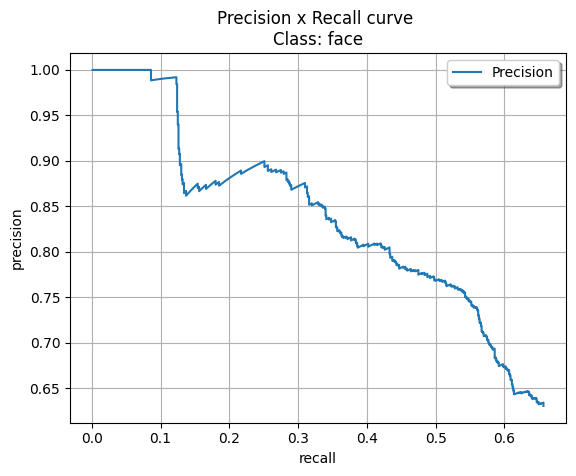

[{'class': 'face',
  'precision': array([1.        , 1.        , 1.        , ..., 0.63173077, 0.63112392,
         0.63051823]),
  'recall': array([0.001, 0.002, 0.003, ..., 0.657, 0.657, 0.657]),
  'AP': 0.5543977692373085,
  'interpolated precision': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9919354838709677,
   0.9919354838709677,
   0.99

In [ ]:
evaluator = Evaluator()
results = evaluator.GetPascalVOCMetrics(bounding_boxes_collection)
evaluator.PlotPrecisionRecallCurve(bounding_boxes_collection)